### Simulating diffraction patterns

The goal is to simulate the diffraction pattern for one compound and crystal system--in this demo, it's cubic NaCl--with a large number of variations. The variations are created by adjusting the lattice parameter lengths of the cubic cell, and we have set the maximum adjustment to each length to be a multiplicative factor of 2. The angles remain unchanged. These variations will serve as datasets for training and testing an ML model that finds peaks in diffraction data.

In [2]:
# Import relevant libraries

import Dans_Diffraction as dif
import Dans_Diffraction.functions_scattering as fs
import numpy as np
import matplotlib.pyplot as plt
import sys

In [32]:
all_crystals = ['BaSO4_orthorhombic', 'NaCl_cubic', 'polypropylene', 'TiO2_tetragonal', 'ZnO_hexagonal']
crystal = all_crystals[3]
cif_file = f'cif_files/{crystal}.cif' 
xtl = dif.Crystal(cif_file) # load in the cif file

Now, we'll define the parameter space that we are exploring. We're starting off with a small number of patterns but the goal is to generate a large number (on the order of 1000) patterns.

In [33]:
orig_lps = xtl.Cell.lp() # starting lattice parameters
lp_multiplier = (2,2,2,1,1,1) # separate multiplier for cell prms
max_lps = np.array(orig_lps) * np.array(lp_multiplier) # max lp_a, lp_b, lp_c, alpha, beta, gamma
num_patterns = 1 # number of variations in lattice prms

all_lps = np.linspace(orig_lps, max_lps, num_patterns) # all variations, including original

Next, we can define our constants. These wavelength and energy values will change for synchrotron data.

In [34]:
# wavelength = 1.5406 # Cu K-alpha
# energy_kev = 8.0478 # Cu K-alpha energy in kEV
wavelength = 0.1665
energy_kev = 74
min_twotheta = 1
max_twotheta = 10
scattering_type = 'xray'

Next, we can calculate the structure factor, which will be used in the intensity function to compute the intensity value.

In [35]:
new_structure_factor = xtl.Scatter.structure_factor # find the structure factor

# This function has been adapted from the Dans-Diffraction library
def intensity(hkl=None, scattering_type=None, int_hkl=None, **options):
    """
    Returns the structure factor squared
            I = |sum( f_i * occ_i * dw_i * exp( -i * 2 * pi * hkl.uvw ) |^2
    Where f_i is the elemental scattering factor, occ_i is the site occupancy, dw_i
    is the Debye-Waller thermal factor, hkl is the reflection and uvw is the site position.

    The following options for scattering_type are  supported:
      'xray'  - uses x-ray form factors
      'neutron' - uses neutron scattering lengths
      'xray magnetic' - calculates the magnetic (non-resonant) component of the x-ray scattering
      'neutron magnetic' - calculates the magnetic component of neutron scattering
      'xray resonant' - calculates magnetic resonant scattering
      'xray dispersion' - uses x-ray form factors including f'-if'' components

    :param hkl: array[n,3] : reflection indexes (h, k, l)
    :param scattering_type: str : one of ['xray','neutron', 'electron', 'xray magnetic','neutron magnetic','xray resonant']
    :param int_hkl: Bool : when True, hkl values are converted to integer.
    :param kwargs: additional options to pass to scattering function
    :return: float array[n] : array of |SF|^2
    """
    return fs.intensity(new_structure_factor(hkl, scattering_type, int_hkl, **options))
new_intensity = intensity

We can then define a function that lists all valid reflections in the form of a numpy array containing lists of indices, two theta values, and integrated area intensities. This is useful for determining the correct number of valid reflections and their two theta values; however, the function does not provide the desired intensity values, which are heights rather than integrated areas.

In [36]:
# This function has been adapted from the Dans-Diffraction library

def list_all_reflections(energy_kev=None, print_symmetric=False,
                              min_intensity=0.01, max_intensity=None, units=None):

    '''
    Returns an np array containing lists of hkl indices, two theta values, and intensities for reflections
    All of these reflections are valid and at the right two theta values; however, the intensity values correspond
    to the integrated areas rather than the peak heights.
    '''
        
    if energy_kev is None:
        energy_kev = ENERGY_KEV
    
    if min_intensity is None: min_intensity = -1
    if max_intensity is None: max_intensity = np.inf
    
    hkl = xtl.Cell.all_hkl(energy_kev, max_twotheta)
    if not print_symmetric:
        hkl = xtl.Symmetry.remove_symmetric_reflections(hkl)
        
    hkl = xtl.Cell.sort_hkl(hkl)

    tth = xtl.Cell.tth(hkl, energy_kev)
    inrange = np.all([tth < max_twotheta, tth > min_twotheta], axis=0)
    hkl = hkl[inrange, :]
    tth = tth[inrange]
    #inten = np.sqrt(self.intensity(hkl)) # structure factor
    inten = intensity(hkl)

    all_info = []

    count = 0
    for n in range(1, len(tth)):
        if inten[n] < min_intensity: continue
        if inten[n] > max_intensity: continue
        count += 1
        all_info.append([hkl[n,0], hkl[n,1], hkl[n,2],tth[n],inten[n]])
    
    return np.array(all_info)

Now, we can define ists, to which we'll append numpy arrays containing the valid reflections (including hkl indices, tth values, and integrated area intensities), two theta values for all the data, intensities for all the data, and the Dans-Diffraction powder-method based reflections (including extra and aphysical reflections but correct intensities). 

In [37]:
valid_refs = [] # contains valid reflections with integrated areas intensities
tths = [] # each lst entry contains an array with all the two theta vals for that set of lattice prms
intensities = [] # same as above, but for intensities
powder_ref1s = [] # contains powder reflections

Here, we can set up the scattering parameters for a 2theta scan, where the scattering_type was defined in an earlier cell, along with the energy_kev and min and max two_theta values. The powder_lorentz value describes the fraction of the simulated scattering pattern that is described by the Lorentz rather than Gauss function in the pseudo-Voigt, and the value was arbitrarily chosen.

In [38]:
xtl.Scatter.setup_scatter(
    scattering_type=scattering_type, 
    powder_units='twotheta', 
    energy_kev=energy_kev,
    min_twotheta=min_twotheta,
    max_twotheta=max_twotheta,
    output=False,
    powder_lorentz=1
)

Now we can fill the lists defined above with all the reflection values and the scattering data. Each appended list contains the relevant information from a single variation of the simulation.

In [39]:
import csv
from tqdm import tqdm

for i in tqdm(range(num_patterns), desc="Setting lattice parameters"):
    xtl.Cell.latt(all_lps[i]) # set lattice prms

    tth1, intensity1, ref1 = xtl.Scatter.powder() # record two theta, intensities, and all reflections including aphysical ones
    tths.append(tth1)
    intensities.append(intensity1)
    powder_ref1s.append(ref1)
    
    real_reflections = list_all_reflections(energy_kev=energy_kev)
    valid_refs.append(real_reflections)

tths = np.array(tths)
intensities = np.array(intensities)
print(tths.shape)

Setting lattice parameters: 100%|██████████| 1/1 [00:00<00:00,  7.65it/s]

(1, 11763)


Here, we'll populate np arrays with the valid reflection two theta values and the corresponding integrated area intensities, which we obtained from the list_all_reflections function and stored in the valid_refs lists. The size of each array corresponds to the maximum possible size, for the variation with the largest number of reflections, so the arrays are initially populated with zeros.

In [40]:
max_refs = max(len(sublist) for sublist in valid_refs)

refs_arr_tths = np.zeros((num_patterns, max_refs))
refs_arr_ints = np.zeros((num_patterns, max_refs))

for i in range(num_patterns):
    for j in range(len(valid_refs[i])):
        refs_arr_tths[i][j] = valid_refs[i][j][3]
        refs_arr_ints[i][j] = valid_refs[i][j][4]

We can separate the output of the Dans-Diffraction powder method for each variation, which we stored in the powder_ref1s list, into lists containing hkl index tuples, tth values, and intensity values.

In [41]:
# Separate ouput of Dans-Diffraction powder method into hkls, tths, intensities, for all variations
powder_ref1_hkls = [] 
powder_ref1_tths = []
powder_ref1_intensities = []

for j in range(num_patterns):
    ref1_tths_pattern = []
    ref1_intensities_pattern = []
    ref1_hkls_pattern = []
    
    for i in range(len(powder_ref1s[j])):
        ref1_hkls_pattern.append((powder_ref1s[j][i][0], powder_ref1s[j][i][1], powder_ref1s[j][i][2]))
        ref1_tths_pattern.append(powder_ref1s[j][i][3])
        ref1_intensities_pattern.append(powder_ref1s[j][i][4])
    
    powder_ref1_hkls.append(ref1_hkls_pattern)
    powder_ref1_tths.append(ref1_tths_pattern)
    powder_ref1_intensities.append(ref1_intensities_pattern)

### Storing the simulated data

Now that we have simulated variations of scattering data for a compound, we need to think about how we'll store the data to make it easy to use in ML models and for plotting purposes. First, we'll create a list that will contain np arrays that each correspond to one variation. The arrays will contain binary values and have the length of the entire set of data in each simulation. A value of 0 will indicate that there is not peak at that 2theta value; 1 will indicate that there is a peak.

In [42]:
import xarray as xr

In [43]:
binary_peaks = [] # empty list that will contain the np arrays

We can define the data types that will be used in an np array that will hold the data for each pattern.

In [44]:
peak_dtype = np.dtype([
    ('hkl', '3i4'),           # tuple of 3 integers
    ('2theta_calc', 'f8'),   # calculated 2θ
    ('2theta_nearest', 'f8'),# nearest 2θ
    ('intensity', 'f8')      # intensity
]) # this is an array that will hold all of the data we want to keep

In [45]:
all_variations = [] # Create a list to hold each variation's reflections

Now we can loop through all the variations and add the relevant values to the all_variations list and the binary_peaks list.

In [46]:
len(powder_ref1_intensities[0])

72

In [47]:
tol = 0.1
max_refs = max(len(sublist) for sublist in powder_ref1_tths)

for j in range(num_patterns):
    binary_peaks_pattern = np.zeros(tths[j].shape[0], dtype=int)
    non_zero_count = np.count_nonzero(refs_arr_tths[j])
    variation_data = np.zeros((non_zero_count), dtype=peak_dtype)

    count = 0

    for i in range(non_zero_count):
        if refs_arr_tths[j][i] == 0:
            continue  # skip zero entries

        diffs = np.abs(powder_ref1_tths[j] - refs_arr_tths[j][i])
        min_idx_powder = np.argmin(diffs)
        
        if diffs[min_idx_powder] < tol:
            idx_powder = min_idx_powder
            variation_data[i] = (
                powder_ref1_hkls[j][idx_powder],
                refs_arr_tths[j][i],
                powder_ref1_tths[j][idx_powder],
                powder_ref1_intensities[j][idx_powder]
            )    
        
        # For binary pattern
        diffs_alldata = np.abs(tths[j] - refs_arr_tths[j][i])
        min_idx_alldata = np.argmin(diffs_alldata)
        if diffs_alldata[min_idx_alldata] < tol:
            binary_peaks_pattern[min_idx_alldata] = 1
            count+=1
            # print(f"Yes: match in tths[{j}] for ref peak {refs_arr_tths[j][i]} (i={i} at hkl {powder_ref1_hkls[j][i]}")
            # print(tths[j][min_idx_alldata])

        else:
            print(f"No match in tths[{j}] for ref peak {refs_arr_tths[j][i]} (i={i})")
    # print(f'count: {count}')

    # print(f"Pattern {j} - Peaks marked: {np.count_nonzero(binary_peaks_pattern)}")
    all_variations.append(variation_data)
    binary_peaks.append(binary_peaks_pattern)
 

In [48]:
print(len(all_variations))

1


In [49]:
# Find the maximum number of peaks across all variations
max_reflections = max(len(arr) for arr in all_variations)

# Initialize arrays with NaNs (to pad if necessary)
hkl_arr = np.full((num_patterns, max_reflections, 3), np.nan)
theta_calc_arr = np.full((num_patterns, max_reflections), np.nan)
theta_nearest_arr = np.full((num_patterns, max_reflections), np.nan)
intensity_arr = np.full((num_patterns, max_reflections), np.nan)

# Fill in values
for i, arr in enumerate(all_variations):
    num_reflections = len(arr)
    hkl_arr[i, :num_reflections] = np.stack([row[0] for row in arr])
    theta_calc_arr[i, :num_reflections] = [row[1] for row in arr]
    theta_nearest_arr[i, :num_reflections] = [row[2] for row in arr]
    intensity_arr[i, :num_reflections] = [row[3] for row in arr]

In [50]:
binary_peaks_pattern.shape

(11763,)

In [51]:
ds_combined = xr.Dataset(
    {
        # These are your xr dataarrays - they can be multidimensional and are indexed to coords (which are also xr dataarrays)
        "Intensities": (["pattern", "tth"], intensities),
        "hkl": (("variation", "peak", "hkl_index"), hkl_arr),
        "2theta_calc": (("variation", "peak"), theta_calc_arr),
        "2theta_nearest": (("variation", "peak"), theta_nearest_arr),
        "intensity": (("variation", "peak"), intensity_arr),
        "binary_arr": (("pattern", "tth"), binary_peaks)
    },
    coords={ # coordinates for indexing your dataarrays 
        "pattern": np.arange(num_patterns),
        "tth": np.linspace(min_twotheta, max_twotheta, tths.shape[1]), # np.linspace(min_tth,max_tth, 11763) or whatever your tth values are
        "variation": np.arange(num_patterns),
        "peak": np.arange(max_reflections),
        "hkl_index": ["h", "k", "l"]
    },
    attrs={ # metadata
        "CIF": cif_file, # you can throw a whole json in here if you like
        "tth_range": (min_twotheta, max_twotheta)
    }
)

In [52]:
print(ds_combined['Intensities'].shape)
print(ds_combined['binary_arr'].shape)

(1, 11763)
(1, 11763)


In [816]:
from zipfile import ZipFile, ZIP_DEFLATED
import os

path = 'saved_data/'
file = f'ds_combined_{num_patterns}_patterns_{crystal}.nc'

ds_combined.to_netcdf(os.path.join(path, file))
with ZipFile(os.path.join(path,file.replace('.nc','.zip')), 'w', ZIP_DEFLATED) as zObject:
    zObject.write(os.path.join(path,file), arcname=file)

In [817]:
f = xr.open_dataset(f'saved_data/{file}')

In [818]:
f['binary_arr']

<xarray.DataArray 'binary_arr' (pattern: 100, tth: 11763)> Size: 9MB
[1176300 values with dtype=int64]
Coordinates:
  * pattern  (pattern) int64 800B 0 1 2 3 4 5 6 7 8 ... 92 93 94 95 96 97 98 99
  * tth      (tth) float64 94kB 1.0 1.001 1.002 1.002 ... 9.998 9.998 9.999 10.0

In [53]:
ds_combined['Intensities'].values

array([[ 0.21287855,  0.21305305,  0.21322776, ..., 28.31340216,
        29.66420737, 31.11280397]], shape=(1, 11763))

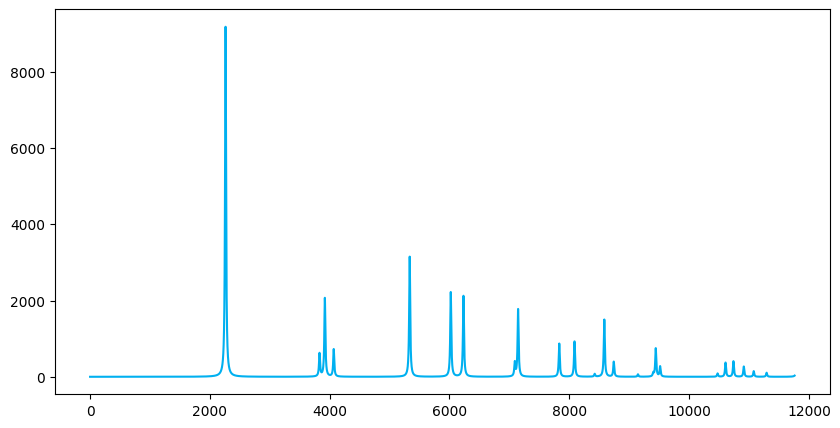

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(ds_combined['Intensities'].values[0], color='#00B0F0')
plt.show()

### Training the ML Model

Now that we have our simulated data and many variations of it for a single compound, we can use the data to train an ML model for classification. We can start with an MLP (multi-layer perceptron) model, which is an artificial neural network.

In [819]:
# Import relevant libraries

from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

Set a random state for reproducibility.

In [820]:
random_state = 42

We can split the data into training and testing datasets. The xdata is the intensity values, whereas the labels are the binary values corresponding to peaks (or lack thereof).

In [821]:
intensities_train, intensities_test, binary_peaks_train, binary_peaks_test = train_test_split(intensities, np.array(binary_peaks), test_size=0.2, random_state=random_state)

Now we need to scale the intensity data.

In [822]:
scaler = MinMaxScaler() # create the scaler object 

intensities_train_sc = scaler.fit_transform(intensities_train) # fit the scaler based on the training data
intensities_test_sc = scaler.transform(intensities_test) # transform test data

The next steps are initializing and training the MLP classifier.

In [823]:
mlp = MLPClassifier(hidden_layer_sizes=(1000, 500, 200, 100,50), max_iter=1000, random_state=random_state, verbose=True,
                   learning_rate_init=0.001,  # Default is 0.001, you can increase or decrease
                    tol=1e-5,
                   early_stopping=False) # initialize MLPClassifier

In [824]:
mlp.fit(intensities_train, binary_peaks_train) # train MLPClassifier

Iteration 1, loss = 155816.41092672
Iteration 2, loss = 137019.97949073
Iteration 3, loss = 88118.09257599
Iteration 4, loss = 75969.64321525
Iteration 5, loss = 54995.26221280
Iteration 6, loss = 33339.23489595
Iteration 7, loss = 29939.83125739
Iteration 8, loss = 18128.21309776
Iteration 9, loss = 10718.73911844
Iteration 10, loss = 6283.68653193
Iteration 11, loss = 3489.84401861
Iteration 12, loss = 1976.75392920
Iteration 13, loss = 1285.34853471
Iteration 14, loss = 1053.67697400
Iteration 15, loss = 1003.75593695
Iteration 16, loss = 1008.68773267
Iteration 17, loss = 1050.30170460
Iteration 18, loss = 1156.10652458
Iteration 19, loss = 1309.51219034
Iteration 20, loss = 1411.85970863
Iteration 21, loss = 1374.59569307
Iteration 22, loss = 1257.05420816
Iteration 23, loss = 1107.49656616
Iteration 24, loss = 1006.61268148
Iteration 25, loss = 942.28714583
Iteration 26, loss = 901.63556977
Iteration 27, loss = 866.18528325
Iteration 28, loss = 833.27660262
Iteration 29, loss = 8

/nsls2/conda/envs/2024-2.0-py311-tiled/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(1000, 500, 200, 100, 50), max_iter=1000,
              random_state=42, tol=1e-05, verbose=True)

### Testing and evaluating the model

Now, we can make predictions using our MLP classifier.

In [825]:
b_peaks_pred = mlp.predict(intensities_test)

Compute the probabilities of each binary class for each feature in each sample.

In [826]:
probs = mlp.predict_proba(intensities_test)

In [827]:
probs.shape # Check that shape is (num_samples, num_features)

(20, 11763)

In [828]:
two_classprobs = np.array([[i,1-i] for i in probs]) # 1-i will give probability for the 0 class

In [829]:
two_classprobs = two_classprobs.reshape((probs.shape[0],probs.shape[1],2)) # reshape to (num_samples, num_features, num_classes)

In [830]:
two_classprobs[0].shape # check that for a single element / sample, the shape is (num_features, num_classes)

(11763, 2)

In [831]:
confidence = np.max(two_classprobs[0], axis=1) # returns max value for each of the features

In [832]:
confidence

array([2.71919341e-26, 9.67410409e-19, 3.25517490e-14, ...,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00])

In [861]:
confidences = []
for i in range(two_classprobs.shape[0]):
    confidence = np.max(two_classprobs[i], axis=1) # returns max value for each of the features
    confidences.append(confidence)
confidences = np.array(confidences)

In [863]:
confidences.shape

(20, 11763)

In [833]:
two_classprobs.T.shape

(2, 11763, 20)

In [834]:
uncertainty = entropy(two_classprobs[0].T)

In [835]:
uncertainty # these are the error bars (from the shannon entropy)

array([5.94756872e-10, 7.26679701e-08, 6.86796787e-01, ...,
       6.93147181e-01, 6.93147181e-01, 6.75300010e-01])

Make array of all the uncertainties, with shape (num_samples, num_features)

In [836]:
uncertainties = []
for i in range(two_classprobs.shape[0]):
    uncertainties.append(entropy(two_classprobs[i].T))
uncertainties = np.array(uncertainties)

In [837]:
uncertainties.shape

(20, 11763)

Here, we can compute the accuracy of our model based on the predictions.

In [838]:
%matplotlib widget

In [839]:
plt.close()

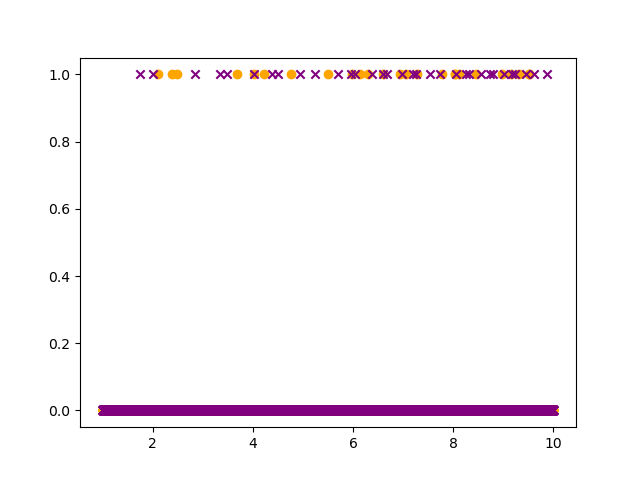

In [840]:
plt.figure()
j = 2
# plt.plot(np.linspace(1,10,11763), intensities_test[j])
plt.scatter(np.linspace(1,10,11763), b_peaks_pred[j], color='orange')
plt.scatter(np.linspace(1,10,11763), binary_peaks_test[j], marker='x', color='purple')

In [858]:
plt.close()

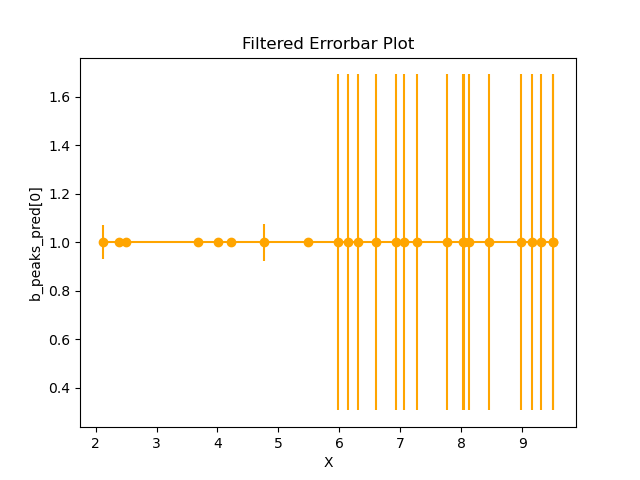

In [859]:
plt.figure()
j = 2

x = np.linspace(1, 10, 11763)
y = b_peaks_pred[j]
yerr = uncertainties[j]

# Mask for values greater than 0
mask = y > 0

# Plot only the valid values
plt.errorbar(x[mask], y[mask], yerr=yerr[mask], marker='o', color='orange')
plt.xlabel("X")
plt.ylabel("b_peaks_pred[0]")
plt.title("Filtered Errorbar Plot")
plt.show()

plt.scatter(np.linspace(1,10,11763), binary_peaks_test[j], marker='x', color='purple')

In [851]:
plt.close()

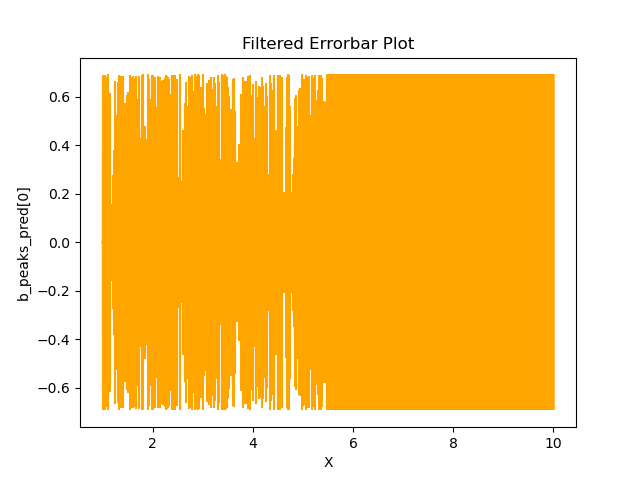

In [852]:
plt.figure()
j = 0

x = np.linspace(1, 10, 11763)
y = b_peaks_pred[j]
yerr = uncertainties[j]

# Mask for values greater than 0
mask = y == 0

# Plot only the valid values
plt.errorbar(x[mask], y[mask], yerr=yerr[mask], color='orange')
plt.xlabel("X")
plt.ylabel("b_peaks_pred[0]")
plt.title("Filtered Errorbar Plot")
plt.show()

plt.scatter(np.linspace(1,10,11763), binary_peaks_test[j], marker='x', color='purple')

In [873]:
plt.close()

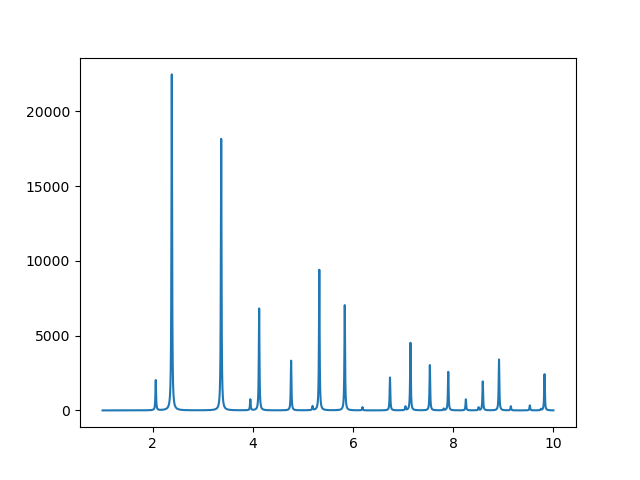

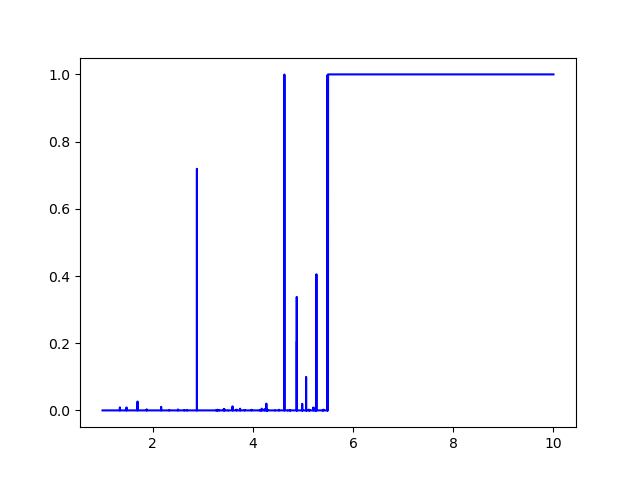

In [874]:
plt.figure()
j = 4
plt.plot(np.linspace(1,10,11763), intensities_test[j])
plt.figure()

plt.plot(np.linspace(1,10,11763), confidences[j], color='blue')

# plt.scatter(np.linspace(1,10,11763), b_peaks_pred[j], color='orange')
# plt.scatter(np.linspace(1,10,11763), binary_peaks_test[j], marker='x', color='purple')

## Scratch Code

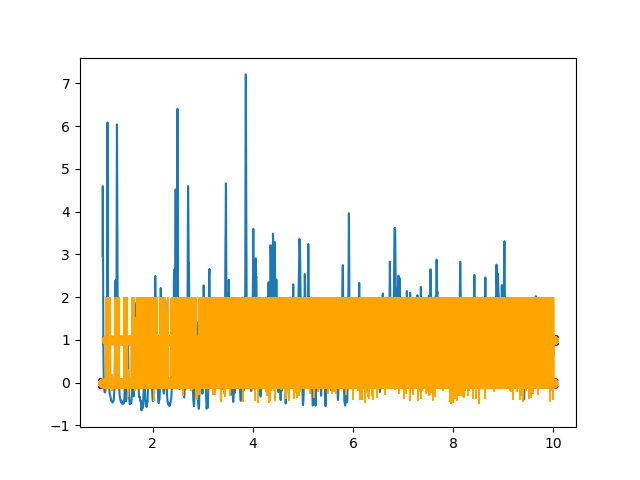

In [516]:
plt.close()
plt.figure()
j = 0
plt.plot(np.linspace(1,10,11763), intensities_test[j])
plt.errorbar(np.linspace(1,10,11763), b_peaks_pred[j], yerr=probabilities, marker='o', color='orange')
plt.scatter(np.linspace(1,10,11763), binary_peaks_test[j], marker='x', color='purple')

In [158]:
b_peaks_pred.shape

(200, 11763)

In [185]:
all_accs = []

for j in range(b_peaks_pred.shape[0]):
    all_accs.append(accuracy_score(binary_peaks_test[j], b_peaks_pred[j]))

print(np.mean(all_accs))

0.99657740372354


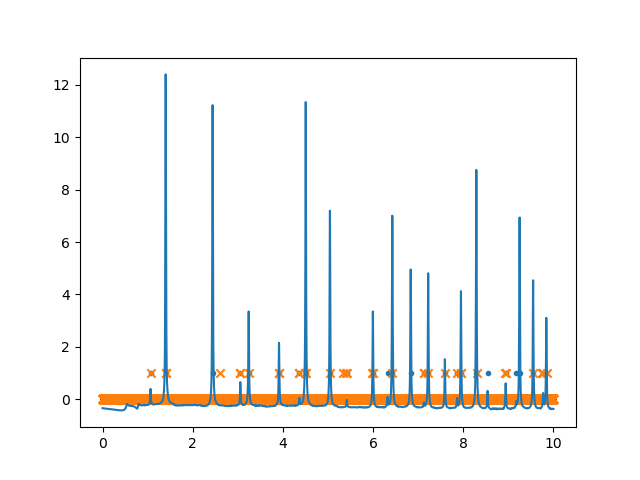

In [207]:
plt.close()

plt.scatter(np.linspace(0,10,11763), np.array(binary_peaks_test[0]), marker='.')
plt.scatter(np.linspace(0,10,11763), b_peaks_pred[0], marker='x')
# for i in range(intensities_test.shape[0]):
plt.plot(np.linspace(0,10,11763), intensities_test[0])
plt.show()

# plot full patterns
# plot only the 1s

In [167]:
print(np.count_nonzero(binary_peaks_test))
print(np.count_nonzero(b_peaks_pred))
print(binary_peaks_test)
print(b_peaks_pred)
diff_indices = np.where(binary_peaks_test != b_peaks_pred)[0]
print(diff_indices)

128
121
[array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


In [168]:
# If it's a list with one array:
binary_peaks_test = binary_peaks_test[0]

In [170]:
print(len(diffs))

98


In [85]:
print(b_peaks_pred[0][70:90])

[1 1 0 0 1 0 0 1 0 0 1 0 0 1 1 0 0 1 0 0]


In [79]:
count = np.count_nonzero(b_peaks_pred[0] == 1)
print(count)

71


In [90]:
count = np.count_nonzero(binary_peaks_test[0][70:] == 1)
print(count)

4


In [103]:
%matplotlib widget

[ 2  3  6  9 10 13 16 17 20 23 26 29 30 33 36 37 40 43 44]


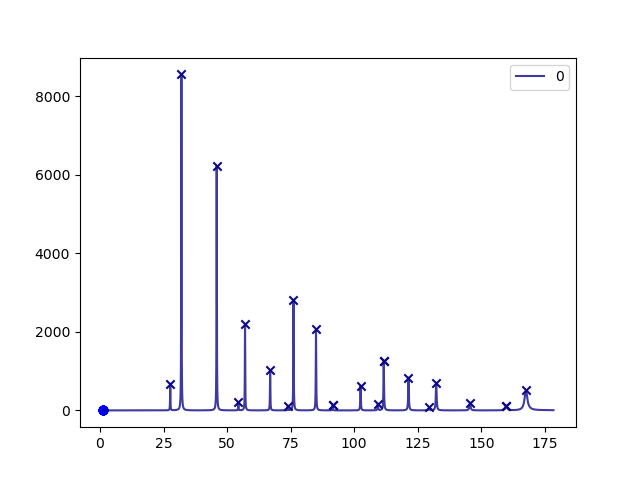

[1.01409262 1.0211179  1.04219374 1.06326962 1.07029492 1.09137084
 1.11244681 1.11947214 1.14054815 1.1616242  1.1827003  1.20377643
 1.21080181 1.231878   1.25295423 1.25997965 1.28105593 1.30213226
 1.30915771]


In [148]:
%matplotlib widget

import matplotlib.cm as cm
colors = cm.plasma(np.linspace(0,1, num_patterns))

# if num_patterns < 6:

#     plt.figure()
    
#     for i in range(num_patterns):
        
#         plt.plot(tths[i],intensities[i], c=colors[i], alpha=0.8, label=f'{i}')
#         # plt.scatter(correct_refs[i][0], correct_refs[i][1], marker='x', color=colors[i])
#         for j in range(len(all_variations[i])):
#             plt.scatter(all_variations[i][j][2], all_variations[i][j][3], marker='x', color=colors[i])
#             plt.scatter(binary_peaks[0], marker='o', color='blue')
#     plt.legend()
#     plt.show()

plt.figure()
    
i = 0
plt.plot(tths[i],intensities[i], c=colors[i], alpha=0.8, label=f'{i}')
indices = np.where(binary_peaks[0] == 1)
print(indices[0])

# plt.scatter(correct_refs[i][0], correct_refs[i][1], marker='x', color=colors[i])
for j in range(len(all_variations[i])):
    plt.scatter(all_variations[i][j][2], all_variations[i][j][3], marker='x', color=colors[i])

plt.scatter(tths[0][indices], intensities[0][indices], marker='o', color='blue')
    # plt.scatter(binary_peaks[0], marker='o', color='blue')

plt.legend()
plt.show()
print(tths[0][indices])

[0. 0. 1. ... 0. 0. 0.]


[-0.86654425 -0.86656016 -0.86657606 ... -3.62749488 -3.60148759
 -3.57547671]


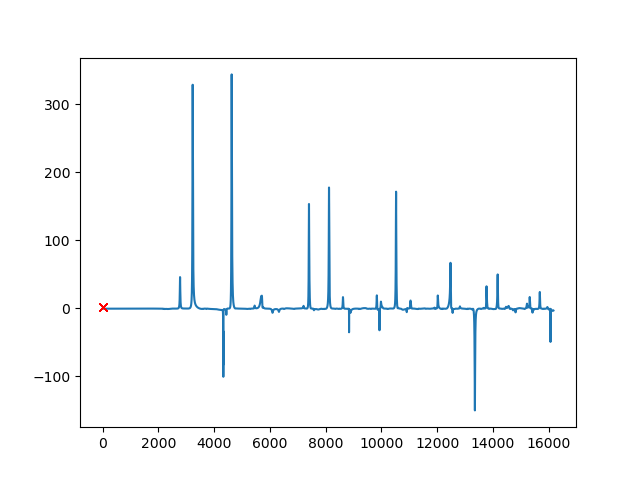

In [104]:
plt.plot(intensities_test[0])

for i in range(len(binary_peaks_test[0])):
    if binary_peaks_test[0][i] == 1:
        plt.plot(binary_peaks_test[0][i], marker='x', color='red')

print(intensities_test[0])

In [ ]:
def prob_norm(array):
    array_sum = array.sum()
    if array_sum != 0:
        array_norm = array / array_sum
    else:
        array_norm = np.ones_like(array) / len(array) # set to a uniform distribution
    return array_norm
def minmax_norm(array):
    array_norm = (array - array.min()) / (array.max() - array.min())
    return array_norm

In [ ]:
accuracy = accuracy_score(binary_peaks_test[0], b_peaks_pred[0])
print(accuracy)

from sklearn.metrics import silhouette_samples, silhouette_score, classification_report, f1_score, precision_score, recall_score

all_f1s = []

for j in range(b_peaks_pred.shape[0]):
    f1 = f1_score(binary_peaks_test[j], b_peaks_pred[j], average=None)
    all_f1s.append(f1)

print(np.mean(all_f1s))